<a href="https://colab.research.google.com/github/quazicynical/DeepSc2/blob/main/deepsc8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install portalocker
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install sentence_transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import math
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'de'

# Place-holders
token_transform = {}
vocab_transform = {}

In [4]:
token_transform[SRC_LANGUAGE] = get_tokenizer('basic_english', language='en')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [5]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [6]:
import torch
from torchtext.datasets import STSB
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
BATCH_SIZE = 128

In [7]:
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [8]:
def SNR_to_noise(snr):
    snr = 10 ** (snr / 10)
    noise_std = 1 / np.sqrt(2 * snr)

    return noise_std

In [16]:
def AWGN(Tx_sig, n_var):
    Rx_sig = Tx_sig + torch.normal(0, n_var, size=Tx_sig.shape).to(DEVICE)
    return Rx_sig

def Rayleigh(Tx_sig, n_var):
    shape = Tx_sig.shape
    H_real = torch.normal(0, math.sqrt(1/2), size=[1]).to(DEVICE)
    H_imag = torch.normal(0, math.sqrt(1/2), size=[1]).to(DEVICE)
    H = torch.Tensor([[H_real, -H_imag], [H_imag, H_real]]).to(DEVICE)
    Tx_sig = torch.matmul(Tx_sig.view(shape[0], -1, 2), H)
    Rx_sig = AWGN(Tx_sig, n_var)
    # Channel estimation
    Rx_sig = torch.matmul(Rx_sig, torch.inverse(H)).view(shape)

    return Rx_sig

noise_std = np.random.uniform(SNR_to_noise(5), SNR_to_noise(10), size=(1))

In [17]:
import random
class Compressor(nn.Module):
    def __init__(self):
      super().__init__()
      self.dense_encoder = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 64))
      self.dense_decoder = nn.Sequential(nn.Linear(64, 128),
                                         nn.ReLU(),
                                         nn.Linear(128, 256),
                                         nn.ReLU(),
                                         nn.Linear(256, 512))
    def forward(self, tensor):
      tensor = self.dense_encoder(tensor)
      tensor = PowerNormalize(tensor)
      noise_std = np.random.uniform(SNR_to_noise(5), SNR_to_noise(10), size=(1))

      noise = torch.rand(tensor.shape)
      noise = noise.to(DEVICE)
      tensor = Rayleigh(tensor,noise_std[0])

      logits = self.dense_decoder(tensor)
      return logits

def PowerNormalize(x):

    x_square = torch.mul(x, x)
    power = torch.mean(x_square).sqrt()
    if power > 1:
        x = torch.div(x, power)

    return x

In [18]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        #self.transformer = Transformer(d_model=emb_size,
        #                               nhead=nhead,
        #                               num_encoder_layers=num_encoder_layers,
        #                               num_decoder_layers=num_decoder_layers,
        #                               dim_feedforward=dim_feedforward,
        #                               dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout), num_layers=3)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout), num_layers=3)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.compressor = Compressor()

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        out1 = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        out3 = self.compressor(out1)
        out2 = self.transformer_decoder(tgt_emb, out3, tgt_mask, None,
                                 tgt_padding_mask, memory_key_padding_mask)
        return self.generator(out2)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)


In [19]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [20]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512 # change here
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, SRC_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [21]:
from torch.utils.data import DataLoader
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        tgt = src
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        tgt = src
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [52]:
from timeit import default_timer as timer
NUM_EPOCHS = 5 #modify

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Epoch: 1, Train loss: 0.319, Val loss: 0.448, Epoch time = 42.536s
Epoch: 2, Train loss: 0.291, Val loss: 0.823, Epoch time = 43.391s
Epoch: 3, Train loss: 0.247, Val loss: 0.579, Epoch time = 42.211s
Epoch: 4, Train loss: 0.278, Val loss: 0.413, Epoch time = 42.548s
Epoch: 5, Train loss: 0.198, Val loss: 0.401, Epoch time = 43.132s


In [53]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    memory = memory.to(DEVICE)
    memory = model.compressor(memory)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [39]:
src = text_transform[SRC_LANGUAGE]("a man eating beans").view(-1, 1)
src

tensor([[   2],
        [   4],
        [   9],
        [ 186],
        [3865],
        [   3]])

In [66]:
print(translate(transformer, "a man eating beans"))

 a man eating hotdogs 


In [67]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer("all-MiniLM-L6-v2")

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like sentence-transformers/all-MiniLM-L6-v2 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [31]:
sentences1 = [
    "The cat sits outside.",
    "A man is playing guitar",
    "A man wearing a coat",
    "The dog ran very fast",
    "The boy had a party",
    "A woman eating a ice cream"
]

s = []
i = 0.01
while(i<1):
  #print(i)
  sentences2 = [
    translate(transformer, "The cat sits outside."),
    translate(transformer, "A man is playing guitar"),
    translate(transformer, "A man wearing a coat"),
    translate(transformer, "The dog ran very fast"),
    translate(transformer, "The boy had a party"),
    translate(transformer, "A woman eating a ice cream")
  ]
  #print(sentences2[0])
  embeddings1 = model.encode(sentences1, convert_to_tensor=True)
  embeddings2 = model.encode(sentences2, convert_to_tensor=True)
  l = []

  cosine_scores = Tensor.cpu(util.cos_sim(embeddings1, embeddings2))
  for j in range(6):
    l.append(cosine_scores[j][j])
  s.append(sum(l)/6)
  i+=0.05


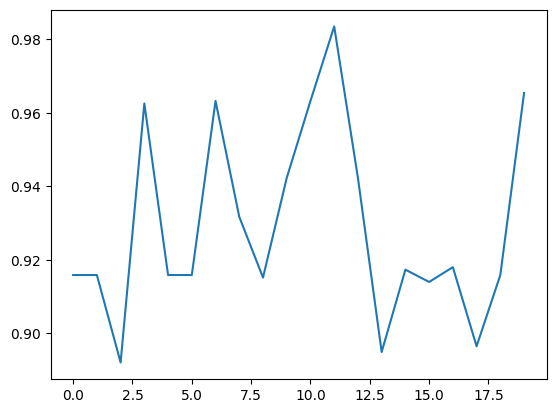

In [32]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(s)

In [39]:
from collections import Counter


class NodeTree(object):
    def _init_(self, left=None, right=None):
        self.left = left
        self.right = right

    def children(self):
        return self.left, self.right

    def _str_(self):
        return self.left, self.right


def huffman_code_tree(node, binString=''):
    '''
    Function to find Huffman Code
    '''
    if type(node) is str:
        return {node: binString}
    (l, r) = node.children()
    d = dict()
    d.update(huffman_code_tree(l, binString + '0'))
    d.update(huffman_code_tree(r, binString + '1'))
    return d


def make_tree(nodes):
    '''
    Function to make tree
    :param nodes: Nodes
    :return: Root of the tree
    '''
    while len(nodes) > 1:
        (key1, c1) = nodes[-1]
        (key2, c2) = nodes[-2]
        nodes = nodes[:-2]
        node = NodeTree()
        node.left = key1
        node.right = key2
        nodes.append((node, c1 + c2))
        nodes = sorted(nodes, key=lambda x: x[1], reverse=True)
    return nodes[0][0]


if (True):
    string = 'a man wearing a coat'
    freq = dict(Counter(string))
    freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    node = make_tree(freq)
    encoding = huffman_code_tree(node)
    for i in encoding:
        print(f'{i} : {encoding[i]}')

i : 0000
r : 0001
c : 0010
g : 0011
  : 01
a : 10
m : 1100
e : 11010
w : 11011
t : 11100
o : 11101
n : 1111


In [40]:
for i in string:
  print(encoding[i],end="")

100111001011110111011110101000010000111100110110010010111011011100

In [2]:
!pip install reedsolo

In [3]:
import time
import reedsolo as rsc

def encoding(per, msg, n, nsym, gen):
    time1 = 0
    count = 0

    rs.init_tables(0x11d)
    while time1 < per:
        temp = time.time()
        s = rs.rs_encode_msg(msg, nsym, gen=gen[nsym])

        time1 += time.time() - temp
        count += 1
    #print(rs.rs_decode(s, nsym, gen=gen[nsym]))
    return s

def main():
    data = b"a man wearing a coat" #This data size is 10MB
    n = 8
    nsym = 3
    period = 10


    gen = rs.rs_generator_poly_all(n)
    encoding(period, data, 8, 3, gen)
    return(gen)

In [4]:
from reedsolo import RSCodec, ReedSolomonError
rsc = RSCodec(10)
a = rsc.encode(b'100111001011110111011110101000010000111100110110010010111011011100')

In [5]:
a

bytearray(b'100111001011110111011110101000010000111100110110010010111011011100X\x9b\x08\xbbQX\x02\xe4M\xd3')

In [33]:
b = rsc.decode(b'100111001011110111011110101111111111111100110110010010111011011100X\x9b\x08\xbbQX\x02\xe4M\xd3')
b

ReedSolomonError: Too many errors to correct

In [37]:
s = "100111001011110111011110101000010000111100110110010010111011011100"
length = len(s)
import torch
noise = torch.rand(1,length)
for i in noise[0]:
  if(i>0.9):
    print(i)

tensor(0.9740)
tensor(0.9719)
tensor(0.9479)
tensor(0.9224)
tensor(0.9146)
tensor(0.9768)
tensor(0.9738)
tensor(0.9521)
tensor(0.9852)


In [30]:
#len("hi")
type(len)
del len